# Digit Recognizer

This work is to build an accurate recognizer to read hand-written digits for a Kaggle competition (https://www.kaggle.com/c/digit-recognizer/overview). 

#### Content
* [1. Introduction](#Part_1)
* [2. Data Preparation](#Part_2)
* [3. Modeling](#Part_3)
    * [3.1 Logistic Model](#Part_3_1)
    * [3.2 XGBoost](#Part_3_2)
    * [3.3 CNN](#Part_3_3)
* [4. Summary and Submissions](#Part_4)

### 1. Introduction <a id='Part_1'></a>

The goal of this work is to build models to recognize the hand-written digit images, so this is a typical classification problem.

The data set used in this work is the famous MNIST data. Each digit image in the data set is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. And Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel.

Several digit recognizers will be built using Logistic model, tree-based boosting methood (XGBoost), and Convolutional Neural Network. The perfomance of the models will be assessed based on the accuracy of classification. The results from the best model will be submitted to Kaggle.


### 2. Data Preparation <a id='Part_2'></a>

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Load and prcess the training and test data.

In [2]:
# Load the data
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

# separate x_train and y_tain
x_train = train.drop(labels=['label'], axis=1)
y_train = train['label']

#### Check the distribution of labels

In [3]:
y_train.value_counts()  # count for each labels

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

/Users/harryliyi/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


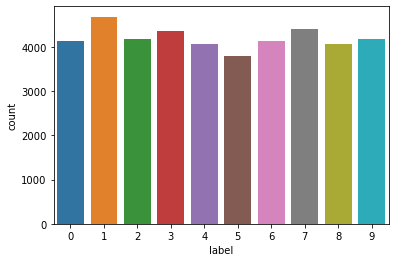

In [4]:
# plot counts for each label
fig = sns.countplot(y_train)

The distribution of labels is quite even, so no need to worry about imbalanced data.

#### Check for missing values

In [5]:
x_train.isnull().sum(axis=1).describe()

count    42000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

In [6]:
test.isnull().sum(axis=1).describe()

count    28000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

There are 42000 training image and 2800 testing image. None of them contains any missing value.

#### Further process data for training

Normalize and reshape the data.

In [7]:
# Normalize the data
x_train = x_train / 255.0
test = test / 255.0

# reshape the data
X_train = x_train.values.reshape(-1, 28, 28, 1)
Test = test.values.reshape(-1, 28, 28, 1)

In [8]:
# Encode labels to one hot vectors (e.g. : 1 -> [0,1,0,0,0,0,0,0,0,0])
Y_train = pd.get_dummies(y_train)
Y_train = Y_train.values

In [9]:
# check if it is converted successfully
print('The label of 1st image is : {}'.format(y_train[0]))
print('The one hot vector of 1st image is : {}'.format(Y_train[0]))

The label of 1st image is : 1
The one hot vector of 1st image is : [0 1 0 0 0 0 0 0 0 0]


#### Take a look at an example image

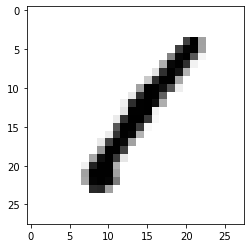

In [10]:
# Some examples
fig = plt.imshow(X_train[0][:,:,0], cmap='binary')

Ok, it matches the label: 1

### 3. Modeling <a id='Part_3'></a>

I will use three different models, including Logistic model, XGBoost, and CNN. 

#### 3.1 Logistic Model <a id='Part_3_1'></a>

Use Logistic model from Scikit-learn as a baseline. For logistic regression, the training data are not needed to be reshaped.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [12]:
# split data set
X_train, X_val, Y_train, Y_val = train_test_split(x_train.values, y_train, test_size=0.1, random_state=23)

In [13]:
# build the logistic model using default parameter
LogisticModel = LogisticRegression(solver = 'lbfgs', multi_class='multinomial', max_iter=1000)

In [14]:
# fitting the training set
LogisticModel.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [15]:
# make the prediction
Lg_preds = LogisticModel.predict(X_val)
# calculate the accuracy based on the validation set
Lg_acc = LogisticModel.score(X_val, Y_val)
print(Lg_acc)

0.9157142857142857


The accuracy is 91.57%, it's not bad.

Take a look at the confusion matrix

Text(0.5, 1, 'Accuracy Score: 91.57%')

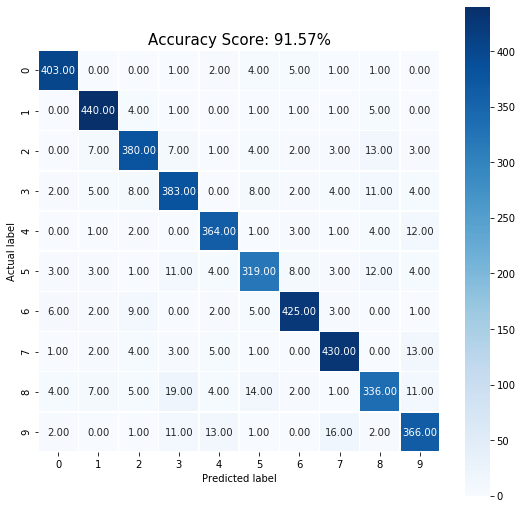

In [16]:
# calculate the confusion matrix
Lg_cm = metrics.confusion_matrix(Y_val, Lg_preds)

plt.figure(figsize=(9,9))
sns.heatmap(Lg_cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0:.2f}%'.format(Lg_acc*100)
plt.title(all_sample_title, size = 15)

Overall, the performance is not bad, but there are some misclassifications between 2 and 8, 8 and 3, 4 and 9, and so on.

#### 3.2 XGBoost <a id='Part_3_2'></a>

Let's see if tree based boosting method can improve performance. The model used here is XGBoost. 

In [17]:
from xgboost import XGBClassifier
import xgboost as xgb

In order to keep the consistency, the same taining and validation sets will be used here.

In [18]:
xgb_clf = XGBClassifier(booster='gbtree', 
                        objective='multi:softmax',
                        max_depth=5, 
                        n_estimators=500, 
                        num_class=10,
                        subsample=0.80,
                        colsample_bytree=0.95
                       )

In [19]:
# train the model
xgb_clf.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
# make the prediction
xgb_preds = xgb_clf.predict(X_val)
# calculate the accuracy based on the validation set
xgb_acc = sum(xgb_preds==Y_val)/len(Y_val)
print(xgb_acc)

0.9761904761904762


The accuracy is 97.62%, it improves a lot from the logistic model. We can take a look at the confusion matrix as well.

Text(0.5, 1, 'XGBoost Accuracy Score: 97.62%')

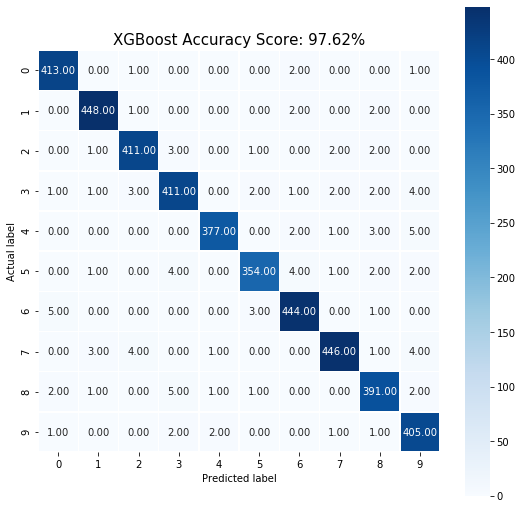

In [21]:
# calculate the confusion matrix
xgb_cm = metrics.confusion_matrix(Y_val, xgb_preds)

plt.figure(figsize=(9,9))
sns.heatmap(xgb_cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'XGBoost Accuracy Score: {0:.2f}%'.format(xgb_acc*100)
plt.title(all_sample_title, size = 15)

#### 3.3 CNN <a id='Part_3_3'></a>

Let's try if CNN model can keep improving the accuracy.

In [34]:
import keras.models as km
import keras.layers as kl
import keras.utils as ku
import keras.optimizers as ko
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
/Users/harryliyi/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/harryliyi/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/harryliyi/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

We need to first define an architecture of CNN. Here I arbitrarily choose a relatively simple CNN architecture. 

The CNN model has two conv2D layers with 16 filters and window size of 5 at first, following with a max pooling layer. Then two conv2D layers with 32 filters and window size of 3 are added to the model, followed by an another max pooling layer. Finally a fully connected NN layer with 256 hidden nodes is added to the model and softmax function is selected as the activation function for the output of the last fully connected NN layer in order to make multiclass prediction. Notice that, to avoid overfitting, a dropout method is used in this CNN, which randomly ignores a proportion of nodes for each traning sample.

In [69]:
def cnn_model(numfm, numnodes, input_shape=(28, 28, 1), output_size=10):
    '''
    numfm: integer, number of filters for the first two Conv2D layers
    numnodes: integer, number of hidden nodes in the fully connected NN layer
    '''

    # Initialize the model.
    model = km.Sequential()

    # Add a 2D convolution layer, with numfm feature maps.
    model.add(kl.Conv2D(numfm, kernel_size=(5, 5),
                        input_shape=input_shape,
                        activation='relu'))
    model.add(kl.Conv2D(numfm, kernel_size=(5, 5),
                        activation='relu'))
    # Add a max pooling layer.
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.25))

    # Second layer
    model.add(kl.Conv2D(numfm * 2, kernel_size=(3, 3),
                        activation='relu'))
    model.add(kl.Conv2D(numfm * 2, kernel_size=(3, 3),
                        activation='relu'))
    # Add a max pooling layer.
    model.add(kl.MaxPooling2D(pool_size=(2, 2),
                              strides=(2, 2)))
    model.add(kl.Dropout(0.25))

    # Convert the network from 2D to 1D.
    model.add(kl.Flatten())

    # Add a fully-connected layer.
    model.add(kl.Dense(numnodes,
                       activation='relu'))
    model.add(kl.Dropout(0.5))
    # Add the output layer.
    model.add(kl.Dense(10, activation='softmax'))

    # Return the model.
    return model

In [89]:
# employ model
cnn_clf = cnn_model(16, 256)
cnn_clf.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 24, 24, 16)        416       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 20, 16)        6416      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 3, 32)         

Next step is to set up the loss function and optimization algorithm. Here I use 'categorical_crossentropy' as the loss function for multiclass classification. The RMSprop optimizer is chosen instead of Stochastic Gradient Descent (sgd), since RMSprop is faster than RMSprop.

In [91]:
# Define the optimizer
optimizer = ko.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
cnn_clf.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, we can gradually reduce the learning rate.

In [92]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',  patience=3,  verbose=1,
                                            factor=0.5,  min_lr=0.00001)

In [93]:
# define maximum epochs and batch size
epochs = 30 
batch_size = 100

In order to train the CNN, the training set needs to be reshaped to 28 by 28 by 1, and the labels need to be encoded to one-hot vectors.

In [94]:
# reshape the training and validation set
X_train_reshape = X_train.reshape(-1, 28, 28, 1)
X_val_reshape = X_val.reshape(-1, 28, 28, 1)

# encode to one-hot vectors
Y_train_dummies = pd.get_dummies(Y_train)
Y_val_dummies = pd.get_dummies(Y_val)
Y_train_dummies = Y_train_dummies.values
Y_val_dummies = Y_val_dummies.values

Let's train the model.

In [95]:
cnn_history = cnn_clf.fit(X_train_reshape, Y_train_dummies, 
                          batch_size = batch_size, 
                          epochs = epochs,
                          validation_data = (X_val_reshape, Y_val_dummies),
                          verbose = 2,
                          callbacks=[learning_rate_reduction]
                   )

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
 - 60s - loss: 0.4469 - accuracy: 0.8548 - val_loss: 0.0898 - val_accuracy: 0.9690
Epoch 2/30
 - 57s - loss: 0.1366 - accuracy: 0.9585 - val_loss: 0.0692 - val_accuracy: 0.9774
Epoch 3/30
 - 59s - loss: 0.0953 - accuracy: 0.9715 - val_loss: 0.0518 - val_accuracy: 0.9831
Epoch 4/30
 - 59s - loss: 0.0780 - accuracy: 0.9761 - val_loss: 0.0561 - val_accuracy: 0.9817
Epoch 5/30
 - 59s - loss: 0.0653 - accuracy: 0.9802 - val_loss: 0.0585 - val_accuracy: 0.9843
Epoch 6/30
 - 58s - loss: 0.0577 - accuracy: 0.9815 - val_loss: 0.0417 - val_accuracy: 0.9879
Epoch 7/30
 - 62s - loss: 0.0536 - accuracy: 0.9833 - val_loss: 0.0424 - val_accuracy: 0.9874
Epoch 8/30
 - 61s - loss: 0.0504 - accuracy: 0.9848 - val_loss: 0.0344 - val_accuracy: 0.9890
Epoch 9/30
 - 57s - loss: 0.0489 - accuracy: 0.9856 - val_loss: 0.0388 - val_accuracy: 0.9871
Epoch 10/30
 - 56s - loss: 0.0455 - accuracy: 0.9865 - val_loss: 0.0390 - val_accuracy: 0.9886
Epoch 11/3

From the record, we can see that the training accuracy is 99.43% and the validation accuracy is 99.26% after 30 epochs. Let's take a look at the confusion matrix.

Text(0.5, 1, 'Accuracy Score: 99.26%')

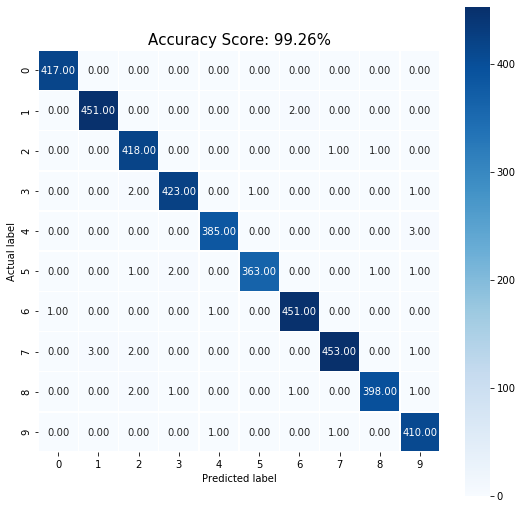

In [97]:
# Predict the values from the validation dataset
cnn_pred_dummies = cnn_clf.predict(X_val_reshape)

# Convert predicted one-hot vectors to classes
cnn_pred = np.argmax(cnn_pred_dummies,axis = 1) 

# calculate the confusion matrix
cnn_cm = metrics.confusion_matrix(Y_val, cnn_pred)

# calculate the accuracy based on the validation set
cnn_acc = sum(cnn_pred==Y_val)/len(Y_val)

# plot the confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cnn_cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0:.2f}%'.format(cnn_acc*100)
plt.title(all_sample_title, size = 15)

Great! CNN shows an even better performance than XGBoost. Can we further improve the accuracy? It should be noted that CNN has 97,274 parameters, while we only have 37800 images for training. Hence there is a risk of overfitting. One way to reduce the risk of overfitting is to artificially expand our handwritten data set by randomly altering the existing images with small transformation. 

In [86]:
# define a image generator
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,        # randomly rotate images (in degrees) in the range
                             zoom_range=0.1,           # Randomly zoom image 
                             width_shift_range=0.1,    # randomly shift images horizontally 
                             height_shift_range=0.1,   # randomly shift images vertically
                             horizontal_flip=False,
                             vertical_flip=False)

datagen.fit(X_train_reshape)

May need to increase epochs as well.

In [99]:
# Reset the model
cnn_new = cnn_model(16, 256)
optimizer = ko.RMSprop(lr=0.002, rho=0.9, epsilon=1e-08, decay=0.0)
cnn_new.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',  patience=3,  verbose=1,
                                            factor=0.5,  min_lr=0.00001)
epochs = 50 

# retrain the CNN model
cnn_history_wtdatagen = cnn_new.fit_generator(datagen.flow(X_train_reshape, Y_train_dummies, batch_size=batch_size),
                                              epochs = epochs,
                                              validation_data = (X_val_reshape, Y_val_dummies),
                                              verbose = 2,
                                              steps_per_epoch = X_train_reshape.shape[0] // batch_size,
                                              callbacks = [learning_rate_reduction]
                                             )

Epoch 1/50
 - 63s - loss: 0.6774 - accuracy: 0.7783 - val_loss: 0.1070 - val_accuracy: 0.9674
Epoch 2/50
 - 60s - loss: 0.2168 - accuracy: 0.9354 - val_loss: 0.0586 - val_accuracy: 0.9824
Epoch 3/50
 - 64s - loss: 0.1598 - accuracy: 0.9525 - val_loss: 0.0509 - val_accuracy: 0.9860
Epoch 4/50
 - 63s - loss: 0.1375 - accuracy: 0.9601 - val_loss: 0.0445 - val_accuracy: 0.9871
Epoch 5/50
 - 60s - loss: 0.1156 - accuracy: 0.9661 - val_loss: 0.0428 - val_accuracy: 0.9867
Epoch 6/50
 - 59s - loss: 0.1109 - accuracy: 0.9686 - val_loss: 0.0496 - val_accuracy: 0.9860
Epoch 7/50
 - 60s - loss: 0.1033 - accuracy: 0.9708 - val_loss: 0.0390 - val_accuracy: 0.9895
Epoch 8/50
 - 61s - loss: 0.0982 - accuracy: 0.9725 - val_loss: 0.0455 - val_accuracy: 0.9876
Epoch 9/50
 - 62s - loss: 0.0965 - accuracy: 0.9722 - val_loss: 0.0600 - val_accuracy: 0.9845
Epoch 10/50
 - 62s - loss: 0.1007 - accuracy: 0.9732 - val_loss: 0.0560 - val_accuracy: 0.9871

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0

Text(0.5, 1, 'CNN with Data Augmentation Accuracy Score: 99.14%')

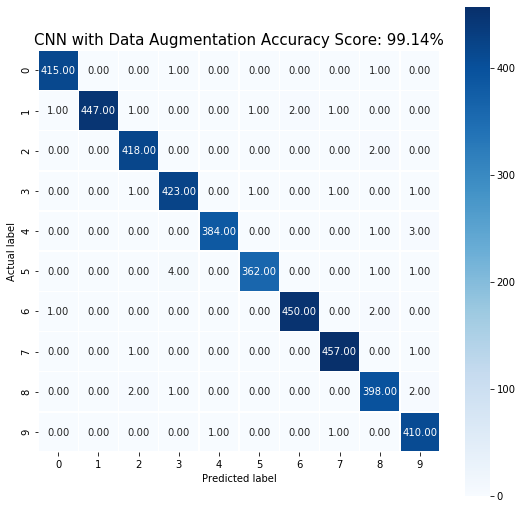

In [100]:
# Predict the values from the validation dataset
cnn_new_pred_dummies = cnn_new.predict(X_val_reshape)

# Convert predicted one-hot vectors to classes
cnn_new_pred = np.argmax(cnn_new_pred_dummies,axis = 1) 

# calculate the confusion matrix
cnn_new_cm = metrics.confusion_matrix(Y_val, cnn_new_pred)

# calculate the accuracy based on the validation set
cnn_new_acc = sum(cnn_new_pred==Y_val)/len(Y_val)

# plot the confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cnn_new_cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'CNN with Data Augmentation Accuracy Score: {0:.2f}%'.format(cnn_new_acc*100)
plt.title(all_sample_title, size = 15)

It seems that CNN with Data Augmentation has a similar performance, the accuracy on the validation set is 99.14%. The validation accuracy is greater than the training accuracy almost evry time during the training, which means that the model doesn't overfit the training set. However the loss of training set is greater, this indicates that this CNN architecture may be too simple, we may need to further increase the complexity of the model, e.g. increase the number of filters to 32, or add more convolution layers. 

### 4. Summary and Submissions <a id='Part_4'></a>

Three different models are used here to recognize the hand-written digits. Basic Logistic model acheives an good accuracy of 91.57%. XGBoost shows a better performance with an accuracy of 97.62% but the training time is much slower than Logistic model. CNN has the best performance and reaches over 99% accuracy! It took me roughly 30 min to train the CNN model on a single CPU core. The training speed will be dramatically improved if training on GPU.

The performance of all three model can be further improved through tuning the hyper-parameters. GridSearchCV from the Scikit-learn package can be used for parameter search. For CNN, increasing the complexity and adding skip connection may be a way to improve the performance. Due to the limit of computational power, I leave the above for future work.

Finally, we can predict the images in the test set and make a submission to Kaggle.

In [102]:
# reshape the training and validation set
Test = test.values.reshape(-1, 28, 28, 1)

# predict results
results = cnn_new.predict(Test)

# select the indix with the maximum probability
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")

submission = pd.concat([pd.Series(range(1, 28001), name="ImageId"), results], axis=1)
submission.to_csv("digit_recognizer_cnn.csv", index=False)